### Imports and Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import resample_poly
import os
import re
import traceback

# Configuration
root_dir = "/Users/sophialiu/Downloads/LAB/dephy"  # Replace with your actual root directory
output_dir = "output_torque"  # Output directory

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Root directory: {root_dir}")
print(f"Output directory: {output_dir}")
print(f"Root directory exists: {os.path.exists(root_dir)}")

Root directory: /Users/sophialiu/Downloads/LAB/dephy
Output directory: output_torque
Root directory exists: True


### File Discovery

In [3]:
# Find all main TSV files (S0x_T0x.tsv format)
tsv_files = []

print("=== File Discovery Process ===")
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.tsv') and re.match(r'^S\d+_T\d+\.tsv$', file):
            print(f"\nFound main TSV file: {file}")
            
            # Get file path
            position_path = os.path.join(root, file)
            
            # Parse main file information
            file_prefix = file[:-4]  # Remove .tsv
            
            # Extract trial number
            match = re.match(r'^S\d+_T(\d+)\.tsv$', file)
            if match:
                trial_num = int(match.group(1))
                
                # Determine left/right foot force data files
                if trial_num in [5, 7]:
                    right_force_file = f"{file_prefix}_f_7.tsv"  # Right foot uses f_7
                    left_force_file = f"{file_prefix}_f_6.tsv"   # Left foot uses f_6
                    print(f"  Trial T{trial_num} - Left/right foot data swapped")
                else:
                    right_force_file = f"{file_prefix}_f_6.tsv"  # Right foot uses f_6
                    left_force_file = f"{file_prefix}_f_7.tsv"   # Left foot uses f_7
                    print(f"  Trial T{trial_num} - Standard left/right foot configuration")
                
                right_force_path = os.path.join(root, right_force_file)
                left_force_path = os.path.join(root, left_force_file)
                
                print(f"  Right foot force file: {right_force_file} - {'exists' if os.path.exists(right_force_path) else 'not found'}")
                print(f"  Left foot force file: {left_force_file} - {'exists' if os.path.exists(left_force_path) else 'not found'}")
                
                # Check if force data files exist and add to processing list
                if os.path.exists(right_force_path):
                    tsv_files.append((position_path, right_force_path, "RIGHT"))
                    print(f"  ✓ Added right foot data pair")
                
                if os.path.exists(left_force_path):
                    tsv_files.append((position_path, left_force_path, "LEFT"))
                    print(f"  ✓ Added left foot data pair")

print(f"\n=== Summary ===")
print(f"Found {len(tsv_files)} matching position and force data file pairs")

# Display all matched file pairs
for i, (pos_path, force_path, side) in enumerate(tsv_files, 1):
    print(f"{i}. {os.path.basename(pos_path)} + {os.path.basename(force_path)} ({side})")

=== File Discovery Process ===

Found main TSV file: S04_T04.tsv
  Trial T4 - Standard left/right foot configuration
  Right foot force file: S04_T04_f_6.tsv - exists
  Left foot force file: S04_T04_f_7.tsv - exists
  ✓ Added right foot data pair
  ✓ Added left foot data pair

Found main TSV file: S04_T05.tsv
  Trial T5 - Left/right foot data swapped
  Right foot force file: S04_T05_f_7.tsv - exists
  Left foot force file: S04_T05_f_6.tsv - exists
  ✓ Added right foot data pair
  ✓ Added left foot data pair

Found main TSV file: S04_T02.tsv
  Trial T2 - Standard left/right foot configuration
  Right foot force file: S04_T02_f_6.tsv - exists
  Left foot force file: S04_T02_f_7.tsv - exists
  ✓ Added right foot data pair
  ✓ Added left foot data pair

Found main TSV file: S04_T07.tsv
  Trial T7 - Left/right foot data swapped
  Right foot force file: S04_T07_f_7.tsv - exists
  Left foot force file: S04_T07_f_6.tsv - exists
  ✓ Added right foot data pair
  ✓ Added left foot data pair

Foun

### Processing Functions Part 1 - Force Plate Analysis

In [4]:
# Cell 3: Processing Functions Part 1 - Force Plate Analysis

def extract_force_plate_corners(right_force_path, left_force_path):
    """Extract all corner coordinates from left and right foot force plate files"""
    try:
        # Extract data from lines 10-21 in right foot file (four corner points)
        print("Extracting corner points from right foot file...")
        with open(right_force_path, 'r') as f:
            lines = f.readlines()
        
        right_corners = []
        for i in range(9, 21):  # Lines 10-21, indices 9-20
            value = float(lines[i].strip().split('\t')[1])
            right_corners.append(value)
        
        # Reorganize into 4 corner points, each with 3 coordinates
        right_points = np.array(right_corners).reshape(4, 3)
        print(f"Right foot four corner points: \n{right_points}")
        
        # Extract data from lines 10-21 in left foot file (four corner points)
        print("Extracting corner points from left foot file...")
        with open(left_force_path, 'r') as f:
            lines = f.readlines()
        
        left_corners = []
        for i in range(9, 21):  # Lines 10-21, indices 9-20
            value = float(lines[i].strip().split('\t')[1])
            left_corners.append(value)
        
        # Reorganize into 4 corner points, each with 3 coordinates
        left_points = np.array(left_corners).reshape(4, 3)
        print(f"Left foot four corner points: \n{left_points}")
        
        return right_points, left_points
        
    except Exception as e:
        print(f"Error extracting force plate corners: {e}")
        return None, None

def calculate_rotation_matrix(corners):
    """Calculate rotation matrix based on four corner points"""
    # Assume corner order: front-left, front-right, back-right, back-left
    # corners[0]: front-left corner  corners[1]: front-right corner
    # corners[2]: back-right corner  corners[3]: back-left corner
    
    # Calculate two main direction vectors of the force plate
    # X direction: from left to right (front-left -> front-right)
    x_vector = corners[1] - corners[0]  # front-right - front-left
    
    # Y direction: from back to front (back-left -> front-left) 
    y_vector = corners[0] - corners[3]  # front-left - back-left
    
    # Normalize vectors
    x_unit = x_vector / np.linalg.norm(x_vector)
    y_unit = y_vector / np.linalg.norm(y_vector)
    
    # Z direction: X × Y
    z_unit = np.cross(x_unit, y_unit)
    z_unit = z_unit / np.linalg.norm(z_unit)
    
    # Recalculate Y direction to ensure orthogonality (Z × X)
    y_unit = np.cross(z_unit, x_unit)
    
    # Build rotation matrix (from force plate coordinate system to global coordinate system)
    rotation_matrix = np.array([x_unit, y_unit, z_unit]).T
    
    print(f"X direction vector: {x_vector}")
    print(f"Y direction vector: {y_vector}")
    print(f"X unit vector: {x_unit}")
    print(f"Y unit vector: {y_unit}")
    print(f"Z unit vector: {z_unit}")
    print(f"Rotation matrix:\n{rotation_matrix}")
    
    return rotation_matrix

def calculate_plate_center_offsets(right_force_path, left_force_path):
    """Calculate left and right foot force plate center offsets and rotation matrices"""
    
    # Extract left and right foot corner coordinates
    right_points, left_points = extract_force_plate_corners(right_force_path, left_force_path)
    
    if right_points is None or left_points is None:
        print("Unable to extract force plate corner coordinates")
        return None, None, None, None
    
    # Calculate right foot force plate center and rotation matrix
    right_center = np.mean(right_points, axis=0)
    right_rotation = calculate_rotation_matrix(right_points)
    right_offset = -right_center  # Take negative value to move center to origin
    
    # Calculate left foot force plate center and rotation matrix
    left_center = np.mean(left_points, axis=0)
    left_rotation = calculate_rotation_matrix(left_points)
    left_offset = -left_center   # Take negative value to move center to origin
    
    print(f"Right foot force plate center: {right_center}")
    print(f"Right foot offset: {right_offset}")
    print(f"Left foot force plate center: {left_center}")
    print(f"Left foot offset: {left_offset}")
    
    return right_offset, left_offset, right_rotation, left_rotation

### Processing Functions Part 2 - Main Processing Function

In [5]:
# Cell 4: Processing Functions Part 2 - Main Processing Function

def process_single_file(position_path, force_path, foot_side, right_force_path=None, left_force_path=None):
    """Process a single file pair and return processing results"""
    try:
        # Extract file information
        file_name = os.path.basename(position_path)
        dir_name = os.path.dirname(position_path)
        subject_id = None
        trial_id = None
        
        # Extract subject_id and trial_id from path
        for part in dir_name.split(os.sep):
            if part.startswith("Subject_"):
                subject_id = part
            elif part.startswith("T0"):
                trial_id = part
        
        # If unable to extract from path, extract from filename
        if not subject_id or not trial_id:
            match = re.match(r'^(S\d+)_(T\d+)\.tsv$', file_name)
            if match:
                subject_code = match.group(1)
                trial_code = match.group(2)
                
                if not subject_id:
                    subject_num = subject_code[1:]
                    subject_id = f"Subject_{subject_num}"
                
                if not trial_id:
                    trial_id = trial_code
        
        key = f"{subject_id}_{trial_id}_{file_name[:-4]}_{foot_side}"
        trial_num = int(re.search(r'T0*(\d+)', trial_id).group(1))
        
        print(f"Processing: {key}")
        
        # Calculate left and right foot force plate center offsets and rotation matrices
        right_plate_offset = None
        left_plate_offset = None
        right_rotation = None
        left_rotation = None
        if right_force_path and left_force_path:
            print("Calculating left and right foot force plate center offsets and rotation matrices...")
            right_plate_offset, left_plate_offset, right_rotation, left_rotation = calculate_plate_center_offsets(right_force_path, left_force_path)
            if right_plate_offset is not None and left_plate_offset is not None:
                right_plate_offset = right_plate_offset / 1000  # mm -> m
                left_plate_offset = left_plate_offset / 1000    # mm -> m
                print(f"Right foot force plate offset (m): {right_plate_offset}")
                print(f"Left foot force plate offset (m): {left_plate_offset}")
        
        # Position Data Processing
        trajectories_df = pd.read_csv(position_path, sep='\t', skiprows=11, header=None)
        
        if foot_side == "RIGHT":
            idx_LatAnkle = 24  
            idx_MedAnkle = 27  
        else:  # LEFT
            idx_LatAnkle = 45  
            idx_MedAnkle = 48  
        
        LatAnkle = trajectories_df.iloc[:, idx_LatAnkle:idx_LatAnkle+3].values.T
        MedAnkle = trajectories_df.iloc[:, idx_MedAnkle:idx_MedAnkle+3].values.T
        AnklePosition = (LatAnkle + MedAnkle) / 2
        AnklePosition /= 1000  # mm → m
        
        # Step 1: Apply corresponding foot force plate center offset
        if foot_side == "RIGHT" and right_plate_offset is not None:
            print("Step 1: Applying right foot force plate center offset...")
            AnklePosition[0, :] += right_plate_offset[0]  # X offset
            AnklePosition[1, :] += right_plate_offset[1]  # Y offset
            AnklePosition[2, :] += right_plate_offset[2]  # Z offset
            
            # Apply rotation transformation from plate corners
            if right_rotation is not None:
                print("Applying right foot rotation transformation...")
                AnklePosition = right_rotation @ AnklePosition
                
        elif foot_side == "LEFT" and left_plate_offset is not None:
            print("Step 1: Applying left foot force plate center offset...")
            AnklePosition[0, :] += left_plate_offset[0]   # X offset
            AnklePosition[1, :] += left_plate_offset[1]   # Y offset
            AnklePosition[2, :] += left_plate_offset[2]   # Z offset
            
            # Apply rotation transformation from plate corners
            if left_rotation is not None:
                print("Applying left foot rotation transformation...")
                AnklePosition = left_rotation @ AnklePosition
        
        # Step 1.5: Apply additional rotation based on trial angle
        angle_mapping = {
            1: 0,
            2: 0,
            4: 5,
            5: -5,
            6: 10,
            7: -10
        }
        plate_angle_deg = angle_mapping.get(trial_num, 0)
        if plate_angle_deg != 0:
            print(f"Applying additional rotation around X-axis by {plate_angle_deg}° to align with plate tilt...")
            angle_rad = np.deg2rad(plate_angle_deg)
            cos_a = np.cos(angle_rad)
            sin_a = np.sin(angle_rad)
            # Rotation matrix around X-axis
            rot_x = np.array([
                [1,      0,       0],
                [0,  cos_a,  -sin_a],
                [0,  sin_a,   cos_a]
            ])
            # Apply rotation to entire trajectory
            AnklePosition = rot_x @ AnklePosition
        
        print(f"Ankle position range after Step 1 offset:")
        print(f"  X: {AnklePosition[0, :].min():.3f} ~ {AnklePosition[0, :].max():.3f}")
        print(f"  Y: {AnklePosition[1, :].min():.3f} ~ {AnklePosition[1, :].max():.3f}")
        print(f"  Z: {AnklePosition[2, :].min():.3f} ~ {AnklePosition[2, :].max():.3f}")
        
        # Step 2: Apply COP global offset
        if foot_side == "RIGHT":
            GLOBAL_OFFSET = np.array([279.4, 889.0, 0.0]) / 1000
        else:
            GLOBAL_OFFSET = np.array([-279.4, 889.0, 0.0]) / 1000
        
        print("Step 2: Applying COP global offset...")
        AnklePosition[0, :] += GLOBAL_OFFSET[0]  # X offset
        AnklePosition[1, :] += GLOBAL_OFFSET[1]  # Y offset
        AnklePosition[2, :] += GLOBAL_OFFSET[2]  # Z offset
        
        print(f"Ankle position range after Step 2 offset:")
        print(f"  X: {AnklePosition[0, :].min():.3f} ~ {AnklePosition[0, :].max():.3f}")
        print(f"  Y: {AnklePosition[1, :].min():.3f} ~ {AnklePosition[1, :].max():.3f}")
        print(f"  Z: {AnklePosition[2, :].min():.3f} ~ {AnklePosition[2, :].max():.3f}")
        
        print(f"Position data completed: {AnklePosition.shape}")
        
        # Force Data Processing
        force_df = pd.read_csv(force_path, sep='\t', skiprows=27, header=None)
        Force = force_df.iloc[:, 0:3].values.T
        COP = force_df.iloc[:, 6:9].values.T
        
        Force_resampled = resample_poly(Force, up=1, down=4, axis=1)
        COP_resampled = resample_poly(COP, up=1, down=4, axis=1)
        
        min_length = min(AnklePosition.shape[1], Force_resampled.shape[1], COP_resampled.shape[1])
        AnklePosition = AnklePosition[:, :min_length]
        Force_resampled = Force_resampled[:, :min_length]
        COP_resampled = COP_resampled[:, :min_length]
        
        print(f"Data alignment completed: {AnklePosition.shape}")
        
        # Torque Calculation
        COP_resampled /= 1000  # mm → m

        if foot_side == "RIGHT":
            FORCE_PLATE_OFFSET = np.array([279.4, 889.0, 0.0]) / 1000
        else:
            FORCE_PLATE_OFFSET = np.array([-279.4, 889.0, 0.0]) / 1000

        COP_global = COP_resampled.copy()
        non_zero_mask = ~(COP_resampled == 0).all(axis=0)
        COP_global[:, non_zero_mask] += FORCE_PLATE_OFFSET[:, np.newaxis]

        ankle_torque = np.zeros_like(Force_resampled)
        non_zero_indices = np.where(non_zero_mask)[0]

        for i in non_zero_indices:
            r = COP_global[:, i] - AnklePosition[:, i]  # Force arm vector from ankle to COP
            f = Force_resampled[:, i]  # Force applied on floor
            ankle_torque[:, i] = np.cross(r, f)  # τ = r × F
        
        # Verify coordinate system correction effect
        print(f"\nCOP global coordinate range:")
        print(f"  X: {COP_global[0, :].min():.3f} ~ {COP_global[0, :].max():.3f}")
        print(f"  Y: {COP_global[1, :].min():.3f} ~ {COP_global[1, :].max():.3f}")
        print(f"  Z: {COP_global[2, :].min():.3f} ~ {COP_global[2, :].max():.3f}")
        
        if len(np.where(non_zero_mask)[0]) > 2000:
            valid_indices = np.where(non_zero_mask)[0]
            valid_idx = valid_indices[2000]  # The 2000th valid point
            print(f"\nCoordinate system correction verification (2000th valid point, index {valid_idx}):")
            print(f"  Ankle position: {AnklePosition[:, valid_idx]}")
            print(f"  COP global position: {COP_global[:, valid_idx]}")
            print(f"  Height difference (ankle-COP): {AnklePosition[2, valid_idx] - COP_global[2, valid_idx]:.3f} m")
        elif len(np.where(non_zero_mask)[0]) > 0:
            valid_idx = np.where(non_zero_mask)[0][0]
            print(f"\nCoordinate system correction verification (first valid point, insufficient valid points < 2000):")
            print(f"  Ankle position: {AnklePosition[:, valid_idx]}")
            print(f"  COP global position: {COP_global[:, valid_idx]}")
            print(f"  Height difference (ankle-COP): {AnklePosition[2, valid_idx] - COP_global[2, valid_idx]:.3f} m")
        
        # Store results
        results = {
            'AnklePosition': AnklePosition,
            'Force_resampled': Force_resampled,
            'ankle_torque': ankle_torque,
            'non_zero_mask': non_zero_mask,
            'key': key,
            'trial_num': trial_num,
            'foot_side': foot_side,
            'subject_code': subject_code if 'subject_code' in locals() else subject_id.split('_')[-1],
            'trial_code': trial_code if 'trial_code' in locals() else trial_id,
            'COP_global': COP_global,
            'position_path': position_path,
            'force_path': force_path,
            'right_plate_offset': right_plate_offset,
            'left_plate_offset': left_plate_offset,
            'right_rotation': right_rotation,
            'left_rotation': left_rotation
        }
        
        print(f"Processing completed successfully!")
        return results
        
    except Exception as e:
        print(f"Error processing file: {e}")
        traceback.print_exc()
        return None

### Plotting Functions

In [6]:
# Cell 5: Plotting Functions

def plot_ankle_position_save(results):
    """Plot ankle position charts and save"""
    AnklePosition = results['AnklePosition']
    key = results['key']
    trial_num = results['trial_num']
    foot_side = results['foot_side']
    
    # Trial description
    trial_description = {
        1: "0° walking (actuated)",
        2: "0° walking (unactuated)",
        4: "5°",
        5: "-5°",
        6: "10°",
        7: "-10°"
    }.get(trial_num, f"T{trial_num}")
    
    frames = np.arange(AnklePosition.shape[1])
    X, Y, Z = AnklePosition[0, :], AnklePosition[1, :], AnklePosition[2, :]
    
    plt.figure(figsize=(15, 10))
    
    # Full data plot
    plt.subplot(2, 2, 1)
    plt.plot(frames, X, label='X', color='b')
    plt.plot(frames, Y, label='Y', color='orange')
    plt.plot(frames, Z, label='Z', color='g')
    plt.legend()
    plt.title(f"{trial_description} - {foot_side} foot - Ankle Position (Complete)")
    plt.xlabel("Frame")
    plt.ylabel("Position (m)")
    
    # Local data plot (middle section)
    start_idx = len(frames) // 3
    end_idx = 2 * len(frames) // 3
    
    plt.subplot(2, 2, 2)
    plt.plot(frames[start_idx:end_idx], X[start_idx:end_idx], label='X', color='b')
    plt.plot(frames[start_idx:end_idx], Y[start_idx:end_idx], label='Y', color='orange')
    plt.plot(frames[start_idx:end_idx], Z[start_idx:end_idx], label='Z', color='g')
    plt.legend()
    plt.title(f"Ankle Position (Middle 1/3 Section)")
    plt.xlabel("Frame")
    plt.ylabel("Position (m)")
    
    # 3D trajectory plot
    ax = plt.subplot(2, 2, 3, projection='3d')
    ax.plot(X, Y, Z, 'b-', alpha=0.6)
    ax.scatter(X[0], Y[0], Z[0], color='green', s=100, label='Start')
    ax.scatter(X[-1], Y[-1], Z[-1], color='red', s=100, label='End')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.legend()
    ax.set_title('Ankle 3D Trajectory')
    
    # Position statistics
    plt.subplot(2, 2, 4)
    stats_data = [
        ['Axis', 'Min (m)', 'Max (m)', 'Mean (m)', 'Std (m)'],
        ['X', f'{X.min():.4f}', f'{X.max():.4f}', f'{X.mean():.4f}', f'{X.std():.4f}'],
        ['Y', f'{Y.min():.4f}', f'{Y.max():.4f}', f'{Y.mean():.4f}', f'{Y.std():.4f}'],
        ['Z', f'{Z.min():.4f}', f'{Z.max():.4f}', f'{Z.mean():.4f}', f'{Z.std():.4f}']
    ]
    
    plt.axis('tight')
    plt.axis('off')
    table = plt.table(cellText=stats_data[1:], colLabels=stats_data[0], 
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Position Statistics')
    
    plt.tight_layout()
    
    # Save plot
    position_plot_path = os.path.join(output_dir, f"{key}_ankle_position_plot.png")
    plt.savefig(position_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Ankle position chart saved: {position_plot_path}")

def plot_torque_data_save(results):
    """Plot torque data charts and save"""
    ankle_torque = results['ankle_torque']
    Force_resampled = results['Force_resampled']
    non_zero_mask = results['non_zero_mask']
    key = results['key']
    trial_num = results['trial_num']
    foot_side = results['foot_side']
    
    trial_description = {
        1: "0° walking (actuated)",
        2: "0° walking (unactuated)",
        4: "5°",
        5: "-5°",
        6: "10°",
        7: "-10°"
    }.get(trial_num, f"T{trial_num}")
    
    plt.figure(figsize=(15, 12))
    
    # Force data (complete)
    plt.subplot(3, 2, 1)
    plt.plot(Force_resampled[0, :], label='Fx', alpha=0.8)
    plt.plot(Force_resampled[1, :], label='Fy', alpha=0.8)
    plt.plot(Force_resampled[2, :], label='Fz', alpha=0.8)
    plt.legend()
    plt.title(f"{trial_description} - {foot_side} foot - Force Data (Complete)")
    plt.xlabel("Frame")
    plt.ylabel("Force (N)")
    
    # Force data (local)
    sample_range = min(5000, Force_resampled.shape[1])
    start_idx = min(20000, Force_resampled.shape[1] - sample_range)
    end_idx = start_idx + sample_range
    
    plt.subplot(3, 2, 2)
    plt.plot(Force_resampled[0, start_idx:end_idx], label='Fx', alpha=0.8)
    plt.plot(Force_resampled[1, start_idx:end_idx], label='Fy', alpha=0.8)
    plt.plot(Force_resampled[2, start_idx:end_idx], label='Fz', alpha=0.8)
    plt.legend()
    plt.title("Force Data (Local)")
    plt.xlabel("Frame")
    plt.ylabel("Force (N)")
    
    # Torque data (complete)
    plt.subplot(3, 2, 3)
    plt.plot(ankle_torque[0, :], label='Torque X', alpha=0.8)
    plt.plot(ankle_torque[1, :], label='Torque Y', alpha=0.8)
    plt.plot(ankle_torque[2, :], label='Torque Z', alpha=0.8)
    plt.legend()
    plt.title("Ankle Torque (Complete)")
    plt.xlabel("Frame")
    plt.ylabel("Torque (N·m)")
    
    # Torque data (local)
    plt.subplot(3, 2, 4)
    plt.plot(ankle_torque[0, start_idx:end_idx], label='Torque X', alpha=0.8)
    plt.plot(ankle_torque[1, start_idx:end_idx], label='Torque Y', alpha=0.8)
    plt.plot(ankle_torque[2, start_idx:end_idx], label='Torque Z', alpha=0.8)
    plt.legend()
    plt.title("Ankle Torque (Local)")
    plt.xlabel("Frame")
    plt.ylabel("Torque (N·m)")
    
    # Y-axis torque analysis (valid data only)
    plt.subplot(3, 2, 5)
    valid_frames = np.where(non_zero_mask)[0]
    valid_torque_y = ankle_torque[1, non_zero_mask]
    plt.plot(valid_frames, valid_torque_y, 'r-', alpha=0.8, linewidth=1.5)
    plt.title("Y-axis Torque (Valid Data Only)")
    plt.xlabel("Frame")
    plt.ylabel("Y-axis Torque (N·m)")
    plt.grid(True, alpha=0.3)
    
    # Torque statistics
    plt.subplot(3, 2, 6)
    if len(valid_torque_y) > 0:
        stats_data = [
            ['Axis', 'Min (N·m)', 'Max (N·m)', 'Mean (N·m)', 'Std (N·m)'],
            ['X', f'{ankle_torque[0, non_zero_mask].min():.2f}', 
             f'{ankle_torque[0, non_zero_mask].max():.2f}', 
             f'{ankle_torque[0, non_zero_mask].mean():.2f}', 
             f'{ankle_torque[0, non_zero_mask].std():.2f}'],
            ['Y', f'{valid_torque_y.min():.2f}', 
             f'{valid_torque_y.max():.2f}', 
             f'{valid_torque_y.mean():.2f}', 
             f'{valid_torque_y.std():.2f}'],
            ['Z', f'{ankle_torque[2, non_zero_mask].min():.2f}', 
             f'{ankle_torque[2, non_zero_mask].max():.2f}', 
             f'{ankle_torque[2, non_zero_mask].mean():.2f}', 
             f'{ankle_torque[2, non_zero_mask].std():.2f}']
        ]
        
        plt.axis('tight')
        plt.axis('off')
        table = plt.table(cellText=stats_data[1:], colLabels=stats_data[0], 
                         cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Torque Statistics (Valid Data)')
    
    plt.tight_layout()
    
    # Save plot
    torque_plot_path = os.path.join(output_dir, f"{key}_torque_plot.png")
    plt.savefig(torque_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Torque chart saved: {torque_plot_path}")

### CSV Save Function

In [7]:
# Cell 6: CSV Save Function

def save_and_update_csv(results):
    """Save torque data and update existing CSV files"""
    if not results:
        print("No result data to save")
        return
    
    ankle_torque = results['ankle_torque']
    key = results['key']
    subject_code = results['subject_code']
    trial_code = results['trial_code']
    foot_side = results['foot_side']
    
    # Save new torque data to CSV
    df = pd.DataFrame({
        'Frame': np.arange(ankle_torque.shape[1]),
        'Torque_X': ankle_torque[0, :],
        'Torque_Y': ankle_torque[1, :],
        'Torque_Z': ankle_torque[2, :]
    })
    
    csv_path = os.path.join(output_dir, f"{key}_torque.csv")
    df.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"Torque data saved to: {csv_path}")
    
    # Find and update existing CSV files
    try:
        pattern_suffix = f"{subject_code}_{trial_code}_{foot_side}.csv"
        print(f"Searching for files ending with '{pattern_suffix}'...")
        
        existing_csv = None
        
        # Search for matching CSV files in entire root directory structure
        for root_search, dirs_search, files_search in os.walk(root_dir):
            for file_search in files_search:
                if file_search.endswith(pattern_suffix):
                    existing_csv = os.path.join(root_search, file_search)
                    print(f"Found matching file: {existing_csv}")
                    break
            if existing_csv:
                break
        
        if existing_csv:
            print(f"Processing existing CSV file: {existing_csv}")
            existing_df = pd.read_csv(existing_csv, sep=',')
            
            # Find first index where "sync" column equals 0
            if 'sync' in existing_df.columns:
                sync_zeros = existing_df[existing_df['sync'] == 0].index
                if len(sync_zeros) > 0:
                    sync_zero_index = sync_zeros[0]
                    print(f"sync=0 starting index: {sync_zero_index}")
                    
                    # Check if Torque columns exist, if not create them
                    for col in ['Torque_X', 'Torque_Y', 'Torque_Z']:
                        if col not in existing_df.columns:
                            existing_df[col] = 0.0
                    
                    # Insert torque data
                    max_rows = min(len(existing_df) - sync_zero_index, ankle_torque.shape[1])
                    existing_df.loc[sync_zero_index:sync_zero_index+max_rows-1, 'Torque_X'] = ankle_torque[0, :max_rows]
                    existing_df.loc[sync_zero_index:sync_zero_index+max_rows-1, 'Torque_Y'] = ankle_torque[1, :max_rows]
                    existing_df.loc[sync_zero_index:sync_zero_index+max_rows-1, 'Torque_Z'] = ankle_torque[2, :max_rows]
                    
                    print(f"Inserted {max_rows} rows of torque data")
                    
                    # Rearrange columns, put Torque columns at the end
                    column_order = [col for col in existing_df.columns if col not in ['Torque_X', 'Torque_Y', 'Torque_Z']]
                    column_order += ['Torque_X', 'Torque_Y', 'Torque_Z']
                    existing_df = existing_df[column_order]
                    
                    # Save updated file
                    updated_csv_path = os.path.join(output_dir, os.path.basename(existing_csv))
                    existing_df.to_csv(updated_csv_path, sep=',', index=False)
                    print(f"Updated existing CSV file and saved to: {updated_csv_path}")
                else:
                    print("No rows found with sync=0 in 'sync' column")
            else:
                print("No 'sync' column found in existing CSV file")
        else:
            print(f"No file found ending with '{pattern_suffix}'")
            
    except Exception as e:
        print(f"Error updating existing CSV: {e}")

### Test Single File

In [8]:
# Cell 8: Test Single File (Recommended - run this before batch processing)

if len(tsv_files) > 0:
    # Find left and right foot force plate files
    right_force_path = None
    left_force_path = None
    
    for position_path, force_path, foot_side in tsv_files:
        if foot_side == "RIGHT":
            right_force_path = force_path
        elif foot_side == "LEFT":
            left_force_path = force_path
    
    print("Available files for testing:")
    for i, (pos_path, force_path, side) in enumerate(tsv_files):
        print(f"{i}: {os.path.basename(pos_path)} ({side})")
    
    # Change this index to test different files
    test_file_index = 1  # <<<< CHANGE THIS NUMBER TO TEST DIFFERENT FILES
    
    if test_file_index < len(tsv_files):
        test_file = tsv_files[test_file_index]
        print(f"\n{'='*60}")
        print(f"Testing file {test_file_index}: {os.path.basename(test_file[0])} ({test_file[2]})")
        print(f"{'='*60}")
        
        test_results = process_single_file(
            test_file[0], test_file[1], test_file[2], 
            right_force_path=right_force_path, 
            left_force_path=left_force_path
        )
        
        if test_results:
            print(f"\n✓ Test completed successfully: {test_results['key']}")
            
            # Display basic statistics
            valid_torque = test_results['ankle_torque'][1, test_results['non_zero_mask']]
            if len(valid_torque) > 0:
                print(f"\nY-axis Ankle Torque Statistics:")
                print(f"  Mean: {valid_torque.mean():.2f} N·m")
                print(f"  Max: {valid_torque.max():.2f} N·m")
                print(f"  Min: {valid_torque.min():.2f} N·m")
                print(f"  Std: {valid_torque.std():.2f} N·m")
            
            # Display ankle position range
            ankle_pos = test_results['AnklePosition']
            print(f"\nAnkle Position Range:")
            print(f"  X: {ankle_pos[0, :].min():.3f} ~ {ankle_pos[0, :].max():.3f} m")
            print(f"  Y: {ankle_pos[1, :].min():.3f} ~ {ankle_pos[1, :].max():.3f} m") 
            print(f"  Z: {ankle_pos[2, :].min():.3f} ~ {ankle_pos[2, :].max():.3f} m")
            
            print(f"\nData shapes:")
            print(f"  Ankle Position: {test_results['AnklePosition'].shape}")
            print(f"  Force: {test_results['Force_resampled'].shape}")
            print(f"  Torque: {test_results['ankle_torque'].shape}")
            print(f"  Valid data points: {np.sum(test_results['non_zero_mask'])}")
            
            print(f"\n{'='*60}")
            print("TEST COMPLETED - You can now:")
            print("1. Run Cell 9 to load interactive plotting functions")
            print("2. Use: plot_ankle_position_interactive(test_results)")
            print("3. Use: plot_torque_data_interactive(test_results)")
            print("4. If satisfied, run Cell 7 for batch processing all files")
            print(f"{'='*60}")
            
        else:
            print(f"\n❌ Test failed for file {test_file_index}")
            print("Please check the file paths and data format")
    else:
        print(f"Invalid test_file_index {test_file_index}. Must be 0-{len(tsv_files)-1}")
        
else:
    print("No files found for testing")
    test_results = None

Available files for testing:
0: S04_T04.tsv (RIGHT)
1: S04_T04.tsv (LEFT)
2: S04_T05.tsv (RIGHT)
3: S04_T05.tsv (LEFT)
4: S04_T02.tsv (RIGHT)
5: S04_T02.tsv (LEFT)
6: S04_T07.tsv (RIGHT)
7: S04_T07.tsv (LEFT)
8: S04_T01.tsv (RIGHT)
9: S04_T01.tsv (LEFT)
10: S04_T06.tsv (RIGHT)
11: S04_T06.tsv (LEFT)
12: S03_T05.tsv (RIGHT)
13: S03_T05.tsv (LEFT)
14: S03_T02.tsv (RIGHT)
15: S03_T02.tsv (LEFT)
16: S03_T04.tsv (RIGHT)
17: S03_T04.tsv (LEFT)
18: S03_T01.tsv (RIGHT)
19: S03_T01.tsv (LEFT)
20: S03_T06.tsv (RIGHT)
21: S03_T06.tsv (LEFT)
22: S03_T07.tsv (RIGHT)
23: S03_T07.tsv (LEFT)
24: S02_T04.tsv (RIGHT)
25: S02_T04.tsv (LEFT)
26: S02_T05.tsv (RIGHT)
27: S02_T05.tsv (LEFT)
28: S02_T02.tsv (RIGHT)
29: S02_T02.tsv (LEFT)
30: S02_T07.tsv (RIGHT)
31: S02_T07.tsv (LEFT)
32: S02_T01.tsv (RIGHT)
33: S02_T01.tsv (LEFT)
34: S02_T06.tsv (RIGHT)
35: S02_T06.tsv (LEFT)
36: S05_T04.tsv (RIGHT)
37: S05_T04.tsv (LEFT)
38: S05_T05.tsv (RIGHT)
39: S05_T05.tsv (LEFT)
40: S05_T02.tsv (RIGHT)
41: S05_T02.tsv (

### Interactive Plotting Functions

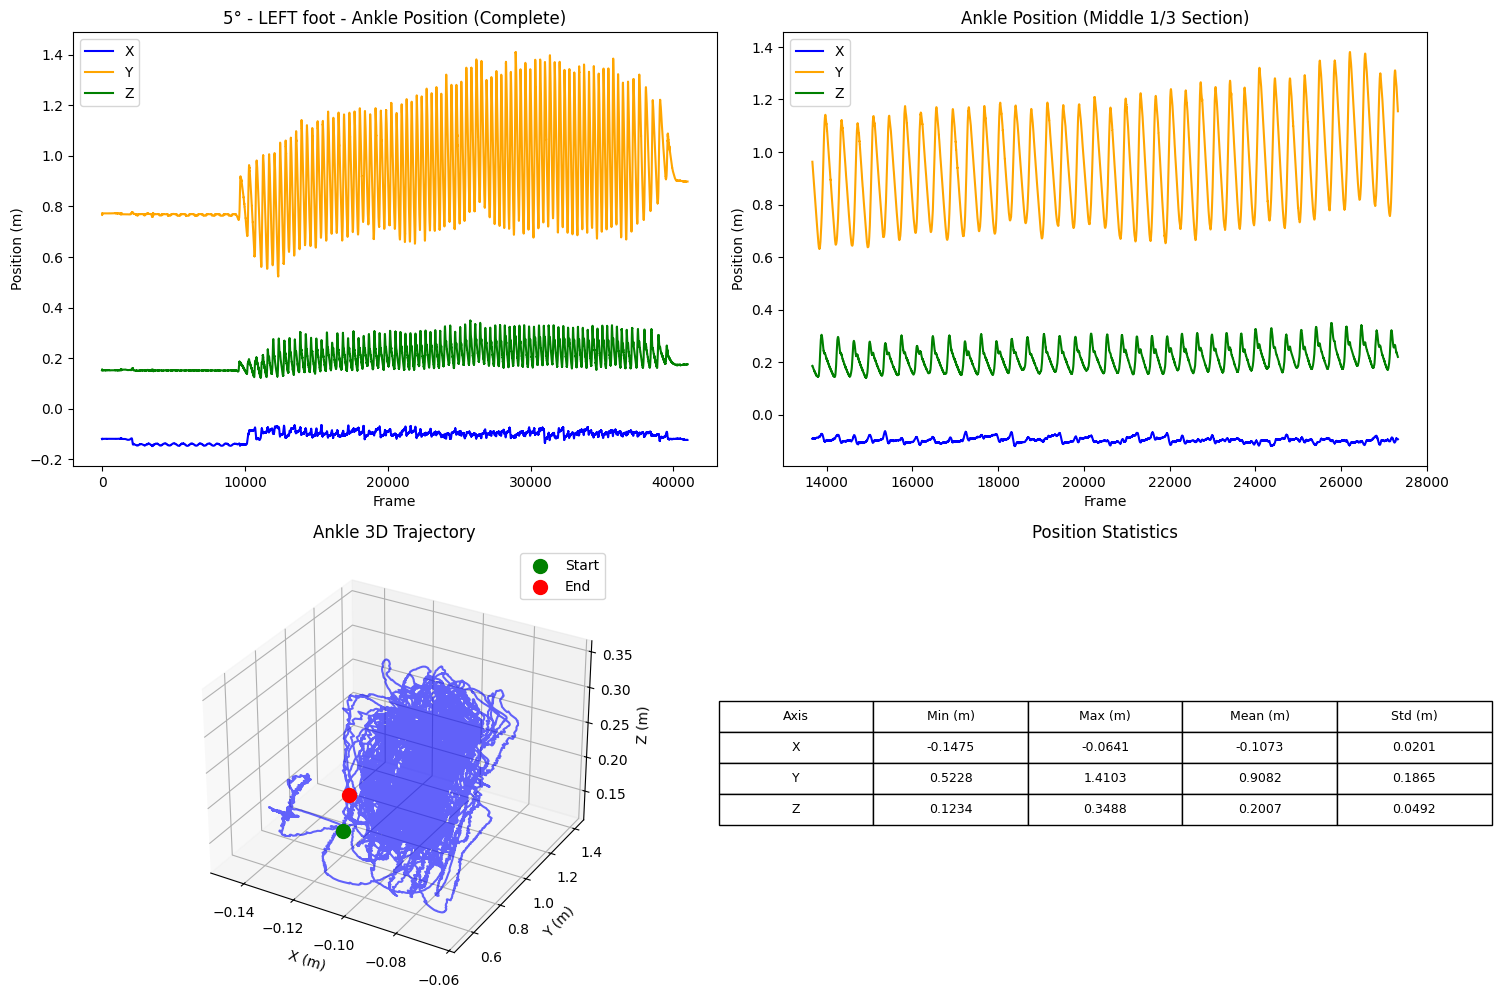

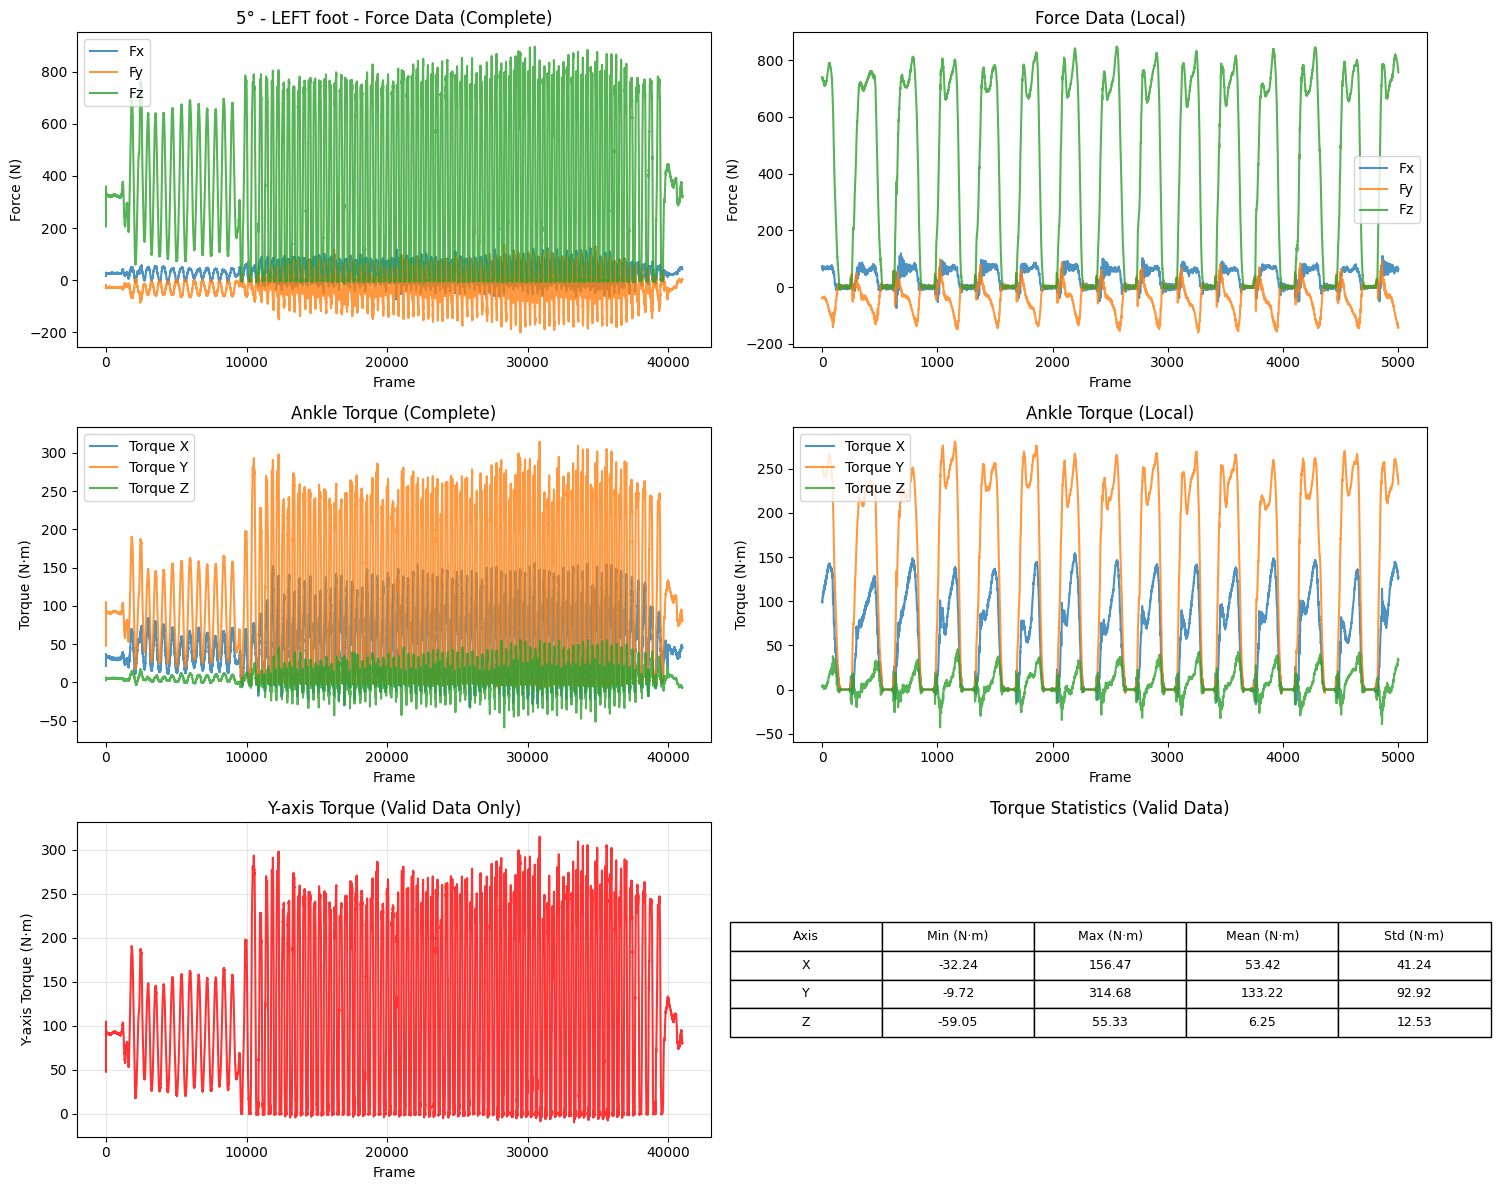

In [9]:
# Cell 9: Interactive Plotting Functions (Optional - for viewing plots in Jupyter)

def plot_ankle_position_interactive(results):
    """Plot ankle position charts interactively in Jupyter"""
    if not results:
        print("No result data to plot")
        return
    
    AnklePosition = results['AnklePosition']
    trial_num = results['trial_num']
    foot_side = results['foot_side']
    
    # Trial description
    trial_description = {
        1: "0° walking (actuated)",
        2: "0° walking (unactuated)",
        4: "5°",
        5: "-5°",
        6: "10°",
        7: "-10°"
    }.get(trial_num, f"T{trial_num}")
    
    frames = np.arange(AnklePosition.shape[1])
    X, Y, Z = AnklePosition[0, :], AnklePosition[1, :], AnklePosition[2, :]
    
    plt.figure(figsize=(15, 10))
    
    # Full data plot
    plt.subplot(2, 2, 1)
    plt.plot(frames, X, label='X', color='b')
    plt.plot(frames, Y, label='Y', color='orange')
    plt.plot(frames, Z, label='Z', color='g')
    plt.legend()
    plt.title(f"{trial_description} - {foot_side} foot - Ankle Position (Complete)")
    plt.xlabel("Frame")
    plt.ylabel("Position (m)")
    
    # Local data plot (middle section)
    start_idx = len(frames) // 3
    end_idx = 2 * len(frames) // 3
    
    plt.subplot(2, 2, 2)
    plt.plot(frames[start_idx:end_idx], X[start_idx:end_idx], label='X', color='b')
    plt.plot(frames[start_idx:end_idx], Y[start_idx:end_idx], label='Y', color='orange')
    plt.plot(frames[start_idx:end_idx], Z[start_idx:end_idx], label='Z', color='g')
    plt.legend()
    plt.title(f"Ankle Position (Middle 1/3 Section)")
    plt.xlabel("Frame")
    plt.ylabel("Position (m)")
    
    # 3D trajectory plot
    ax = plt.subplot(2, 2, 3, projection='3d')
    ax.plot(X, Y, Z, 'b-', alpha=0.6)
    ax.scatter(X[0], Y[0], Z[0], color='green', s=100, label='Start')
    ax.scatter(X[-1], Y[-1], Z[-1], color='red', s=100, label='End')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.legend()
    ax.set_title('Ankle 3D Trajectory')
    
    # Position statistics
    plt.subplot(2, 2, 4)
    stats_data = [
        ['Axis', 'Min (m)', 'Max (m)', 'Mean (m)', 'Std (m)'],
        ['X', f'{X.min():.4f}', f'{X.max():.4f}', f'{X.mean():.4f}', f'{X.std():.4f}'],
        ['Y', f'{Y.min():.4f}', f'{Y.max():.4f}', f'{Y.mean():.4f}', f'{Y.std():.4f}'],
        ['Z', f'{Z.min():.4f}', f'{Z.max():.4f}', f'{Z.mean():.4f}', f'{Z.std():.4f}']
    ]
    
    plt.axis('tight')
    plt.axis('off')
    table = plt.table(cellText=stats_data[1:], colLabels=stats_data[0], 
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Position Statistics')
    
    plt.tight_layout()
    plt.show()

def plot_torque_data_interactive(results):
    """Plot torque data charts interactively in Jupyter"""
    if not results:
        print("No result data to plot")
        return
    
    ankle_torque = results['ankle_torque']
    Force_resampled = results['Force_resampled']
    non_zero_mask = results['non_zero_mask']
    trial_num = results['trial_num']
    foot_side = results['foot_side']
    
    trial_description = {
        1: "0° walking (actuated)",
        2: "0° walking (unactuated)",
        4: "5°",
        5: "-5°",
        6: "10°",
        7: "-10°"
    }.get(trial_num, f"T{trial_num}")
    
    plt.figure(figsize=(15, 12))
    
    # Force data (complete)
    plt.subplot(3, 2, 1)
    plt.plot(Force_resampled[0, :], label='Fx', alpha=0.8)
    plt.plot(Force_resampled[1, :], label='Fy', alpha=0.8)
    plt.plot(Force_resampled[2, :], label='Fz', alpha=0.8)
    plt.legend()
    plt.title(f"{trial_description} - {foot_side} foot - Force Data (Complete)")
    plt.xlabel("Frame")
    plt.ylabel("Force (N)")
    
    # Force data (local)
    sample_range = min(5000, Force_resampled.shape[1])
    start_idx = min(20000, Force_resampled.shape[1] - sample_range)
    end_idx = start_idx + sample_range
    
    plt.subplot(3, 2, 2)
    plt.plot(Force_resampled[0, start_idx:end_idx], label='Fx', alpha=0.8)
    plt.plot(Force_resampled[1, start_idx:end_idx], label='Fy', alpha=0.8)
    plt.plot(Force_resampled[2, start_idx:end_idx], label='Fz', alpha=0.8)
    plt.legend()
    plt.title("Force Data (Local)")
    plt.xlabel("Frame")
    plt.ylabel("Force (N)")
    
    # Torque data (complete)
    plt.subplot(3, 2, 3)
    plt.plot(ankle_torque[0, :], label='Torque X', alpha=0.8)
    plt.plot(ankle_torque[1, :], label='Torque Y', alpha=0.8)
    plt.plot(ankle_torque[2, :], label='Torque Z', alpha=0.8)
    plt.legend()
    plt.title("Ankle Torque (Complete)")
    plt.xlabel("Frame")
    plt.ylabel("Torque (N·m)")
    
    # Torque data (local)
    plt.subplot(3, 2, 4)
    plt.plot(ankle_torque[0, start_idx:end_idx], label='Torque X', alpha=0.8)
    plt.plot(ankle_torque[1, start_idx:end_idx], label='Torque Y', alpha=0.8)
    plt.plot(ankle_torque[2, start_idx:end_idx], label='Torque Z', alpha=0.8)
    plt.legend()
    plt.title("Ankle Torque (Local)")
    plt.xlabel("Frame")
    plt.ylabel("Torque (N·m)")
    
    # Y-axis torque analysis (valid data only)
    plt.subplot(3, 2, 5)
    valid_frames = np.where(non_zero_mask)[0]
    valid_torque_y = ankle_torque[1, non_zero_mask]
    plt.plot(valid_frames, valid_torque_y, 'r-', alpha=0.8, linewidth=1.5)
    plt.title("Y-axis Torque (Valid Data Only)")
    plt.xlabel("Frame")
    plt.ylabel("Y-axis Torque (N·m)")
    plt.grid(True, alpha=0.3)
    
    # Torque statistics
    plt.subplot(3, 2, 6)
    if len(valid_torque_y) > 0:
        stats_data = [
            ['Axis', 'Min (N·m)', 'Max (N·m)', 'Mean (N·m)', 'Std (N·m)'],
            ['X', f'{ankle_torque[0, non_zero_mask].min():.2f}', 
             f'{ankle_torque[0, non_zero_mask].max():.2f}', 
             f'{ankle_torque[0, non_zero_mask].mean():.2f}', 
             f'{ankle_torque[0, non_zero_mask].std():.2f}'],
            ['Y', f'{valid_torque_y.min():.2f}', 
             f'{valid_torque_y.max():.2f}', 
             f'{valid_torque_y.mean():.2f}', 
             f'{valid_torque_y.std():.2f}'],
            ['Z', f'{ankle_torque[2, non_zero_mask].min():.2f}', 
             f'{ankle_torque[2, non_zero_mask].max():.2f}', 
             f'{ankle_torque[2, non_zero_mask].mean():.2f}', 
             f'{ankle_torque[2, non_zero_mask].std():.2f}']
        ]
        
        plt.axis('tight')
        plt.axis('off')
        table = plt.table(cellText=stats_data[1:], colLabels=stats_data[0], 
                         cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Torque Statistics (Valid Data)')
    
    plt.tight_layout()
    plt.show()

plot_ankle_position_interactive(test_results)
plot_torque_data_interactive(test_results)

### Main Batch Processing

In [76]:
# Cell 7: Main Batch Processing

if len(tsv_files) > 0:
    # Find left and right foot force plate files for the first available trial
    right_force_path = None
    left_force_path = None
    
    for position_path, force_path, foot_side in tsv_files:
        if foot_side == "RIGHT":
            right_force_path = force_path
        elif foot_side == "LEFT":
            left_force_path = force_path
        
        # If we have both, we can break early
        if right_force_path and left_force_path:
            break
    
    print(f"\n{'='*80}")
    print(f"Starting batch processing of {len(tsv_files)} files...")
    
    all_results = []
    for i, (position_path, force_path, foot_side) in enumerate(tsv_files, 1):
        print(f"\n{'='*80}")
        print(f"Processing file {i}/{len(tsv_files)}")
        
        # Process single file
        result = process_single_file(
            position_path, force_path, foot_side, 
            right_force_path=right_force_path, 
            left_force_path=left_force_path
        )
        
        if result:
            print(f"Generating ankle position chart...")
            plot_ankle_position_save(result)
            
            print(f"Generating torque chart...")
            plot_torque_data_save(result)
            
            print(f"Saving CSV data...")
            save_and_update_csv(result)
            
            all_results.append(result)
            
            # Print Y-axis torque statistics
            valid_torque = result['ankle_torque'][1, result['non_zero_mask']]
            if len(valid_torque) > 0:
                print(f"Y-axis Ankle Torque Statistics:")
                print(f"  Mean: {valid_torque.mean():.2f} N·m")
                print(f"  Max: {valid_torque.max():.2f} N·m")
                print(f"  Min: {valid_torque.min():.2f} N·m")
            
            print(f"✓ File {i} processing completed")
        else:
            print(f"❌ File {i} processing failed")
    
    print(f"\n{'='*80}")
    print(f"Batch processing completed: Successfully processed {len(all_results)}/{len(tsv_files)} files")
    print(f"Results saved to: {output_dir}")
    
    # Store results for potential further analysis
    batch_results = all_results
    
    # Display summary statistics
    if all_results:
        print(f"\n=== SUMMARY STATISTICS ===")
        for result in all_results:
            valid_torque = result['ankle_torque'][1, result['non_zero_mask']]
            if len(valid_torque) > 0:
                print(f"{result['key']}: Y-torque mean={valid_torque.mean():.2f} N·m, range=[{valid_torque.min():.2f}, {valid_torque.max():.2f}] N·m")
    
else:
    print("No files found for processing")
    batch_results = None


Starting batch processing of 48 files...

Processing file 1/48
Processing: Subject_04_T04_S04_T04_RIGHT
Calculating left and right foot force plate center offsets and rotation matrices...
Extracting corner points from right foot file...
Right foot four corner points: 
[[ 507.676721 1415.532112   -1.6083  ]
 [1066.476464 1416.136622   -1.7554  ]
 [1068.399668 -361.862302   -2.9716  ]
 [ 509.599984 -362.466902   -2.8246  ]]
Extracting corner points from left foot file...
Left foot four corner points: 
[[-5.36165980e+01  1.41179073e+03 -3.67540000e+00]
 [ 5.05180538e+02  1.41119647e+03 -1.91920000e+00]
 [ 5.03287435e+02 -3.66802901e+02 -1.19880000e+00]
 [-5.55097010e+01 -3.66208583e+02 -2.95500000e+00]]
X direction vector: [ 5.58799743e+02  6.04510000e-01 -1.47100000e-01]
Y direction vector: [-1.92326300e+00  1.77799901e+03  1.21630000e+00]
X unit vector: [ 9.99999380e-01  1.08180011e-03 -2.63242621e-04]
Y unit vector: [-1.08161982e-03  9.99999181e-01  6.84083038e-04]
Z unit vector: [ 2.

Traceback (most recent call last):
  File "/var/folders/t3/md7qww213qzg03zk21mthb6r0000gn/T/ipykernel_18895/1389526878.py", line 81, in process_single_file
    AnklePosition[0, :] += left_plate_offset[0]   # X offset
    ~~~~~~~~~~~~~^^^^^^
IndexError: index 0 is out of bounds for axis 0 with size 0


Step 1: Applying right foot force plate center offset...
Applying right foot rotation transformation...
Ankle position range after Step 1 offset:
  X: -0.263 ~ -0.093
  Y: -0.791 ~ 0.447
  Z: 0.122 ~ 0.396
Step 2: Applying COP global offset...
Ankle position range after Step 2 offset:
  X: 0.016 ~ 0.187
  Y: 0.098 ~ 1.336
  Z: 0.122 ~ 0.396
Position data completed: (3, 110417)
Data alignment completed: (3, 110417)

COP global coordinate range:
  X: 0.244 ~ 0.397
  Y: 0.795 ~ 1.178
  Z: 0.000 ~ 0.000

Coordinate system correction verification (2000th valid point, index 2000):
  Ankle position: [0.12242683 0.76455134 0.12920485]
  COP global position: [0.27983208 1.03633166 0.        ]
  Height difference (ankle-COP): 0.129 m
Processing completed successfully!
Generating ankle position chart...
  ✓ Ankle position chart saved: output_torque/Subject_03_T02_S03_T02_RIGHT_ankle_position_plot.png
Generating torque chart...
  ✓ Torque chart saved: output_torque/Subject_03_T02_S03_T02_RIGHT_tor

Traceback (most recent call last):
  File "/var/folders/t3/md7qww213qzg03zk21mthb6r0000gn/T/ipykernel_18895/1389526878.py", line 81, in process_single_file
    AnklePosition[0, :] += left_plate_offset[0]   # X offset
    ~~~~~~~~~~~~~^^^^^^
IndexError: index 0 is out of bounds for axis 0 with size 0


Data alignment completed: (3, 41486)

COP global coordinate range:
  X: -0.144 ~ 0.679
  Y: -0.719 ~ 2.263
  Z: 0.000 ~ 0.000

Coordinate system correction verification (2000th valid point, index 2000):
  Ankle position: [-0.09337667  1.00521846  0.1068461 ]
  COP global position: [0.1111103  0.94822606 0.        ]
  Height difference (ankle-COP): 0.107 m
Processing completed successfully!
Generating ankle position chart...
  ✓ Ankle position chart saved: output_torque/Subject_03_T07_S03_T07_RIGHT_ankle_position_plot.png
Generating torque chart...
  ✓ Torque chart saved: output_torque/Subject_03_T07_S03_T07_RIGHT_torque_plot.png
Saving CSV data...
Torque data saved to: output_torque/Subject_03_T07_S03_T07_RIGHT_torque.csv
Searching for files ending with 'S03_T07_RIGHT.csv'...
Found matching file: /Users/sophialiu/Downloads/LAB/dephy/Fully Processed Dataset with all the 4 variables/subject_processed/S03/20230428_1552_S03_T07_RIGHT.csv
Processing existing CSV file: /Users/sophialiu/Downl

In [10]:
### Acceleration and Torque Comparison Plot
# Add this function after the existing plotting functions

def plot_acceleration_torque_comparison(results, existing_csv_path=None):
    """Plot acceleration data (columns 3,4,5) and torque data for comparison"""
    
    if not results:
        print("No result data to plot")
        return
    
    # Extract necessary data from results
    key = results['key']
    subject_code = results['subject_code']
    trial_code = results['trial_code']
    foot_side = results['foot_side']
    trial_num = results['trial_num']
    
    # Trial description
    trial_description = {
        1: "0° walking (actuated)",
        2: "0° walking (unactuated)",
        4: "5°",
        5: "-5°",
        6: "10°",
        7: "-10°"
    }.get(trial_num, f"T{trial_num}")
    
    # If no existing_csv_path provided, search for the updated file in output directory
    if not existing_csv_path:
        pattern_suffix = f"{subject_code}_{trial_code}_{foot_side}.csv"
        print(f"Searching for updated files ending with '{pattern_suffix}' in output directory...")
        
        # First check in output directory
        for file_search in os.listdir(output_dir):
            if file_search.endswith(pattern_suffix):
                existing_csv_path = os.path.join(output_dir, file_search)
                print(f"Found updated file in output directory: {existing_csv_path}")
                break
        
        # If not found in output dir, search in root directory
        if not existing_csv_path:
            for root_search, dirs_search, files_search in os.walk(root_dir):
                for file_search in files_search:
                    if file_search.endswith(pattern_suffix):
                        existing_csv_path = os.path.join(root_search, file_search)
                        print(f"Found matching file: {existing_csv_path}")
                        break
                if existing_csv_path:
                    break
    
    if not existing_csv_path or not os.path.exists(existing_csv_path):
        print("Could not find existing CSV file with acceleration data")
        return
    
    try:
        # Read the CSV file
        print(f"Reading CSV file: {existing_csv_path}")
        df = pd.read_csv(existing_csv_path)
        
        # Find sync start point
        if 'sync' not in df.columns:
            print("No 'sync' column found in CSV file")
            return
        
        sync_zeros = df[df['sync'] == 0].index
        if len(sync_zeros) == 0:
            print("No rows found with sync=0")
            return
        
        sync_zero_index = sync_zeros[0]
        print(f"sync=0 starting index: {sync_zero_index}")
        
        # Extract acceleration data (columns 3, 4, 5 - assuming 0-indexed)
        # In pandas, columns are typically named, so we'll use iloc for positional indexing
        accel_x = df.iloc[sync_zero_index:, 2].values  # Column 3 (0-indexed: 2)
        accel_y = df.iloc[sync_zero_index:, 3].values  # Column 4 (0-indexed: 3)
        accel_z = df.iloc[sync_zero_index:, 4].values  # Column 5 (0-indexed: 4)
        
        # Get column names for labeling
        col_names = df.columns.tolist()
        accel_x_name = col_names[2] if len(col_names) > 2 else "Accel_X"
        accel_y_name = col_names[3] if len(col_names) > 3 else "Accel_Y"
        accel_z_name = col_names[4] if len(col_names) > 4 else "Accel_Z"
        
        # Extract torque data from the CSV file (should be in the last 3 columns)
        if 'Torque_X' in df.columns and 'Torque_Y' in df.columns and 'Torque_Z' in df.columns:
            print("Using torque data from CSV file")
            torque_x = df.loc[sync_zero_index:, 'Torque_X'].values
            torque_y = df.loc[sync_zero_index:, 'Torque_Y'].values
            torque_z = df.loc[sync_zero_index:, 'Torque_Z'].values
        else:
            print("Torque columns not found in CSV, using data from results")
            # Fall back to using torque data from results if not in CSV
            ankle_torque = results['ankle_torque']
            torque_x = ankle_torque[0, :]
            torque_y = ankle_torque[1, :]
            torque_z = ankle_torque[2, :]
        
        # Align data lengths
        min_length = min(len(accel_x), len(torque_x))
        accel_x = accel_x[:min_length]
        accel_y = accel_y[:min_length]
        accel_z = accel_z[:min_length]
        torque_x = torque_x[:min_length]
        torque_y = torque_y[:min_length]
        torque_z = torque_z[:min_length]
        
        # Create time array (assuming 1000 Hz for motion capture)
        time = np.arange(min_length) / 1000.0  # Convert to seconds

        # print(f"Time range: {time[0]:.3f}s ~ {time[-1]:.3f}s")

        # Crop to desired time window (e.g., 0 to 3 seconds)
        # Crop to a time window (e.g., 1s to 3s)
        start_time = 10  # seconds
        end_time = 20    # seconds

        # Find index range for the time window
        start_idx = np.searchsorted(time, start_time)
        end_idx = np.searchsorted(time, end_time)

        # Slice data to this window
        time = time[start_idx:end_idx]
        accel_x = accel_x[start_idx:end_idx]
        accel_y = accel_y[start_idx:end_idx]
        accel_z = accel_z[start_idx:end_idx]
        torque_x = torque_x[start_idx:end_idx]
        torque_y = torque_y[start_idx:end_idx]
        torque_z = torque_z[start_idx:end_idx]


        
        # Create figure with subplots
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        fig.suptitle(f'{trial_description} - {foot_side} foot - Acceleration vs Torque Comparison', fontsize=16)
        
        # Plot X-axis data
        ax1 = axes[0, 0]
        ax1.plot(time, accel_x, 'b-', alpha=0.8, label=accel_x_name)
        ax1.set_ylabel('Acceleration (unit)', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_xlabel('Time (s)')
        ax1.grid(True, alpha=0.3)
        ax1.set_title('X-axis Acceleration')
        
        ax2 = axes[0, 1]
        ax2.plot(time, torque_x, 'r-', alpha=0.8, label='Torque X')
        ax2.set_ylabel('Torque (N·m)', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.set_xlabel('Time (s)')
        ax2.grid(True, alpha=0.3)
        ax2.set_title('X-axis Torque')
        
        # Plot Y-axis data
        ax3 = axes[1, 0]
        ax3.plot(time, accel_y, 'b-', alpha=0.8, label=accel_y_name)
        ax3.set_ylabel('Acceleration (unit)', color='b')
        ax3.tick_params(axis='y', labelcolor='b')
        ax3.set_xlabel('Time (s)')
        ax3.grid(True, alpha=0.3)
        ax3.set_title('Y-axis Acceleration')
        
        ax4 = axes[1, 1]
        ax4.plot(time, torque_y, 'r-', alpha=0.8, label='Torque Y')
        ax4.set_ylabel('Torque (N·m)', color='r')
        ax4.tick_params(axis='y', labelcolor='r')
        ax4.set_xlabel('Time (s)')
        ax4.grid(True, alpha=0.3)
        ax4.set_title('Y-axis Torque')
        
        # Plot Z-axis data
        ax5 = axes[2, 0]
        ax5.plot(time, accel_z, 'b-', alpha=0.8, label=accel_z_name)
        ax5.set_ylabel('Acceleration (unit)', color='b')
        ax5.tick_params(axis='y', labelcolor='b')
        ax5.set_xlabel('Time (s)')
        ax5.grid(True, alpha=0.3)
        ax5.set_title('Z-axis Acceleration')
        
        ax6 = axes[2, 1]
        ax6.plot(time, torque_z, 'r-', alpha=0.8, label='Torque Z')
        ax6.set_ylabel('Torque (N·m)', color='r')
        ax6.tick_params(axis='y', labelcolor='r')
        ax6.set_xlabel('Time (s)')
        ax6.grid(True, alpha=0.3)
        ax6.set_title('Z-axis Torque')
        
        plt.tight_layout()
        
        # Save plot
        output_path = os.path.join(output_dir, f"{key}_acceleration_torque_comparison.png")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✓ Acceleration-Torque comparison plot saved: {output_path}")
        
        # Also create an overlay plot for better comparison
        fig2, axes2 = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
        fig2.suptitle(f'{trial_description} - {foot_side} foot - Acceleration & Torque Overlay', fontsize=16)
        
        # X-axis overlay
        ax1 = axes2[0]
        ax1_twin = ax1.twinx()
        ax1.plot(time, accel_x, 'b-', alpha=0.7, label=f'{accel_x_name}')
        ax1_twin.plot(time, torque_x, 'r-', alpha=0.7, label='Torque X')
        ax1.set_ylabel('Acceleration', color='b')
        ax1_twin.set_ylabel('Torque (N·m)', color='r')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1_twin.tick_params(axis='y', labelcolor='r')
        ax1.grid(True, alpha=0.3)
        ax1.set_title('X-axis')
        ax1.legend(loc='upper left')
        ax1_twin.legend(loc='upper right')
        
        # Y-axis overlay
        ax2 = axes2[1]
        ax2_twin = ax2.twinx()
        ax2.plot(time, accel_y, 'b-', alpha=0.7, label=f'{accel_y_name}')
        ax2_twin.plot(time, torque_y, 'r-', alpha=0.7, label='Torque Y')
        ax2.set_ylabel('Acceleration', color='b')
        ax2_twin.set_ylabel('Torque (N·m)', color='r')
        ax2.tick_params(axis='y', labelcolor='b')
        ax2_twin.tick_params(axis='y', labelcolor='r')
        ax2.grid(True, alpha=0.3)
        ax2.set_title('Y-axis')
        ax2.legend(loc='upper left')
        ax2_twin.legend(loc='upper right')
        
        # Z-axis overlay
        ax3 = axes2[2]
        ax3_twin = ax3.twinx()
        ax3.plot(time, accel_z, 'b-', alpha=0.7, label=f'{accel_z_name}')
        ax3_twin.plot(time, torque_z, 'r-', alpha=0.7, label='Torque Z')
        ax3.set_ylabel('Acceleration', color='b')
        ax3_twin.set_ylabel('Torque (N·m)', color='r')
        ax3.tick_params(axis='y', labelcolor='b')
        ax3_twin.tick_params(axis='y', labelcolor='r')
        ax3.set_xlabel('Time (s)')
        ax3.grid(True, alpha=0.3)
        ax3.set_title('Z-axis')
        ax3.legend(loc='upper left')
        ax3_twin.legend(loc='upper right')
        
        plt.tight_layout()
        
        # Save overlay plot
        overlay_path = os.path.join(output_dir, f"{key}_acceleration_torque_overlay.png")
        plt.savefig(overlay_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✓ Acceleration-Torque overlay plot saved: {overlay_path}")
        
        # Print statistics
        print(f"\nAcceleration Statistics (from sync point):")
        print(f"  {accel_x_name}: Mean={np.mean(accel_x):.3f}, Std={np.std(accel_x):.3f}, Range=[{np.min(accel_x):.3f}, {np.max(accel_x):.3f}]")
        print(f"  {accel_y_name}: Mean={np.mean(accel_y):.3f}, Std={np.std(accel_y):.3f}, Range=[{np.min(accel_y):.3f}, {np.max(accel_y):.3f}]")
        print(f"  {accel_z_name}: Mean={np.mean(accel_z):.3f}, Std={np.std(accel_z):.3f}, Range=[{np.min(accel_z):.3f}, {np.max(accel_z):.3f}]")
        
    except Exception as e:
        print(f"Error creating acceleration-torque comparison plot: {e}")
        traceback.print_exc()


# Modified main batch processing to include acceleration-torque comparison
def process_with_acceleration_comparison(tsv_files):
    """Process files and create acceleration-torque comparison plots"""
    
    if len(tsv_files) == 0:
        print("No files found for processing")
        return
    
    # Find left and right foot force plate files
    right_force_path = None
    left_force_path = None
    
    for position_path, force_path, foot_side in tsv_files:
        if foot_side == "RIGHT":
            right_force_path = force_path
        elif foot_side == "LEFT":
            left_force_path = force_path
        
        if right_force_path and left_force_path:
            break
    
    print(f"\n{'='*80}")
    print(f"Starting batch processing with acceleration comparison for {len(tsv_files)} files...")
    
    all_results = []
    for i, (position_path, force_path, foot_side) in enumerate(tsv_files, 1):
        print(f"\n{'='*80}")
        print(f"Processing file {i}/{len(tsv_files)}")
        
        # Process single file
        result = process_single_file(
            position_path, force_path, foot_side, 
            right_force_path=right_force_path, 
            left_force_path=left_force_path
        )
        
        if result:
            print(f"Generating ankle position chart...")
            plot_ankle_position_save(result)
            
            print(f"Generating torque chart...")
            plot_torque_data_save(result)
            
            print(f"Saving CSV data...")
            save_and_update_csv(result)
            
            # New: Generate acceleration-torque comparison plot
            print(f"Generating acceleration-torque comparison...")
            plot_acceleration_torque_comparison(result)
            
            all_results.append(result)
            
            # Print Y-axis torque statistics
            valid_torque = result['ankle_torque'][1, result['non_zero_mask']]
            if len(valid_torque) > 0:
                print(f"Y-axis Ankle Torque Statistics:")
                print(f"  Mean: {valid_torque.mean():.2f} N·m")
                print(f"  Max: {valid_torque.max():.2f} N·m")
                print(f"  Min: {valid_torque.min():.2f} N·m")
            
            print(f"✓ File {i} processing completed")
        else:
            print(f"❌ File {i} processing failed")
    
    print(f"\n{'='*80}")
    print(f"Batch processing completed: Successfully processed {len(all_results)}/{len(tsv_files)} files")
    print(f"Results saved to: {output_dir}")
    
    return all_results


# Example usage for testing single file with acceleration comparison
if 'test_results' in globals() and test_results:
    print("\n" + "="*60)
    print("Creating acceleration-torque comparison for test file...")
    plot_acceleration_torque_comparison(test_results)
    print("Test comparison completed!")
    print("="*60)


# New function to plot from updated CSV files in output directory
def plot_all_updated_csv_files():
    """Plot acceleration and torque data from all updated CSV files in output directory"""
    
    print(f"\n{'='*80}")
    print(f"Searching for updated CSV files in output directory: {output_dir}")
    
    # Find all CSV files that match the pattern in output directory
    csv_files = []
    for file in os.listdir(output_dir):
        if file.endswith('.csv') and not file.endswith('_torque.csv'):
            # Check if it matches the pattern: *_S##_T##_[LEFT|RIGHT].csv
            if re.search(r'_S\d+_T\d+_(LEFT|RIGHT)\.csv', file):
                csv_files.append(file)
    
    if not csv_files:
        print("No updated CSV files found in output directory")
        return
    
    print(f"Found {len(csv_files)} updated CSV files to process:")
    for i, file in enumerate(csv_files, 1):
        print(f"  {i}. {file}")
    
    # Process each file
    for i, csv_file in enumerate(csv_files, 1):
        print(f"\n{'='*60}")
        print(f"Processing file {i}/{len(csv_files)}: {csv_file}")
        
        csv_path = os.path.join(output_dir, csv_file)
        
        try:
            # Extract information from filename
            match = re.search(r'_S(\d+)_T(\d+)_(LEFT|RIGHT)\.csv', csv_file)
            if match:
                subject_num = match.group(1)
                trial_num = int(match.group(2))
                foot_side = match.group(3)
                
                # Create a minimal results dict for the plotting function
                results = {
                    'key': csv_file[:-4],  # Remove .csv extension
                    'subject_code': f'S{subject_num}',
                    'trial_code': f'T{trial_num:02d}',
                    'foot_side': foot_side,
                    'trial_num': trial_num,
                    'ankle_torque': None  # Will be read from CSV
                }
                
                # Call the plotting function with the CSV path
                plot_acceleration_torque_comparison(results, existing_csv_path=csv_path)
                print(f"✓ Successfully processed {csv_file}")
            else:
                print(f"❌ Could not parse filename: {csv_file}")
                
        except Exception as e:
            print(f"❌ Error processing {csv_file}: {e}")
            traceback.print_exc()
    
    print(f"\n{'='*80}")
    print(f"Completed processing all CSV files in output directory")
    print(f"Plots saved to: {output_dir}")


# Example: To plot all updated CSV files after batch processing
plot_all_updated_csv_files()


Creating acceleration-torque comparison for test file...
Searching for updated files ending with '04_T04_LEFT.csv' in output directory...
Found updated file in output directory: output_torque/20230502_1316_S04_T04_LEFT.csv
Reading CSV file: output_torque/20230502_1316_S04_T04_LEFT.csv
sync=0 starting index: 323
Using torque data from CSV file
✓ Acceleration-Torque comparison plot saved: output_torque/Subject_04_T04_S04_T04_LEFT_acceleration_torque_comparison.png
✓ Acceleration-Torque overlay plot saved: output_torque/Subject_04_T04_S04_T04_LEFT_acceleration_torque_overlay.png

Acceleration Statistics (from sync point):
  accel_x: Mean=-0.113, Std=0.455, Range=[-2.935, 1.756]
  accel_y: Mean=1.092, Std=0.579, Range=[-0.884, 4.000]
  accel_z: Mean=-0.094, Std=0.268, Range=[-1.461, 1.687]
Test comparison completed!

Searching for updated CSV files in output directory: output_torque
Found 46 updated CSV files to process:
  1. 20230425_1621_S02_T06_LEFT.csv
  2. 20230502_1316_S04_T04_RIGHT